In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



In [2]:
# define fixed parameters

#conductances
C_m = 1.0e-9

# volatages
V_leak = -40.0e-3 # 40 mV
V_Ca = 100.0e-3 # 100mV
V_k = -80.0e-3 # -80mV
V_h = -20.0e-3 # -20mV
V_syn = -75.0e-3 # -75mV

v_1 = 0.0 # 0mV
v_2 = 20.0e-3 # 20mV
v_3 = 0.0 # 0mV
v_4 = 15.0e-3 # 15mV
v_5 = 78.3e-3 # 78.3mV
v_6 = 10.5e-3 # 10.5mV
v_7 = -42.2e-3 # -42.2mV
v_8 = 87.3e-3 # 87.3mV
v_9 = 5.0e-3  # 5.0mV

v_th = -25.0e-3 # -25mV

# neuron specific conductances
g_Ca_f = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_Ca_h = 1.7e-2 * (1e-6) # 1.7e-2 \mu S
g_Ca_s = 8.5e-3 * (1e-6) # 8.5e-3 \mu S

g_k_f  = 3.9e-2 * (1e-6) # 3.9e-2 \mu S
g_k_h  = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_k_s  = 1.5e-2 * (1e-6) # 1.5e-2 \mu S

g_h_f  = 2.5e-2 * (1e-6) # 2.5e-2 \mu S
g_h_h  = 8.0e-3 * (1e-6) # 8.0e-3 \mu S
g_h_s  = 1.0e-2 * (1e-6) # 1.0e-2 \mu S

g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

g_leak = 1.0e-4 * (1e-6) # 1e-4 \mu S

phi_N = 2 # 0.002 ms^-1


    

## state representation

The state variable $x$ is comprised of three, five-dimensional state variables ($V_m$, $N$, and $H$) for each neuron.

$$x = \begin{bmatrix} V_m \\ N \\ H \end{bmatrix}$$
$$V_m = \begin{bmatrix} V_{m,f_1} \\ V_{m,f_2} \\ V_{m,h_n} \\ V_{m,s_1} \\ V_{m,s_2} \end{bmatrix} \hspace{1cm}
N = \begin{bmatrix} N_{f_1} \\ N_{f_2} \\ N_{h_n} \\ N_{s_1} \\ N_{s_2} \end{bmatrix} \hspace{1cm}
H = \begin{bmatrix} H_{f_1} \\ H_{f_2} \\ H_{h_n} \\ H_{s_1} \\ H_{s_2} \end{bmatrix} 
$$

In [3]:

def f(x, g_el, g_synA, g_synB):
    # x contains
    V_m = x[:5]
    N = x[5:10]
    H = x[10:]
    
    M_inf = 0.5*(1.0 + np.tanh((V_m - v_1)/ v_2))
    N_inf = 0.5*(1.0 + np.tanh((V_m - v_3)/v_4))
    H_inf = 1.0 / (1.0 + np.exp((V_m + v_5)/v_6))
                   
    S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))
    
    I_leak = g_leak*(V_m - V_leak)
    I_Ca = g_Ca*M_inf*(V_m - V_Ca)
    I_k = g_k*N*(V_m - V_k)
    I_h = g_h*H*(V_m - V_h)
                   
    I_elec = np.array([0.0, 
                       g_el*(V_m[1]-V_m[2]),
                       g_el*(V_m[2]-V_m[1] + V_m[2]-V_m[4]),
                       0.0,
                       g_el*(V_m[4]-V_m[2])])
                   
    I_syn = np.array([g_synB*S_inf[1]*(V_m[0] - V_syn),
                        g_synB*S_inf[0]*(V_m[1] - V_syn),
                        g_synA*S_inf[0]*(V_m[2] - V_syn) + g_synA*S_inf[3]*(V_m[2] - V_syn),
                        g_synB*S_inf[4]*(V_m[3] - V_syn),
                        g_synB*S_inf[3]*(V_m[4] - V_syn)])

    I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn    
    
    lambda_N = (phi_N)*np.cosh((V_m - v_3)/(2*v_4))
    tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0
    
    dVmdt = (1.0 / C_m)*(-I_total)
    dNdt = lambda_N*(N_inf - N)
    dHdt = (H_inf - H) / tau_h
    
    dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
    return dxdt
                   

In [51]:
# parameters for the DSN
g_el = np.arange(0.2, 8.0, 0.8) * (1e-9) # .25 nS  (.25-7.5 nS) range
g_synA = np.arange(0.25, 8.0, 1.0) * (1e-9) # .25 nS  (.25-10 nS) range
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

num_g_el = g_el.shape[0]
num_g_synA = g_synA.shape[0]

In [77]:
import time
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

V_m0 = -65.0e-3*np.ones((5,))
N_0 = 0.25*np.ones((5,))
H_0 = 0.1*np.ones((5,))
x0 = np.concatenate((V_m0, N_0, H_0), axis=0)
x = x0
T = 104000
fft_start = 4000
dt = 0.001

w = 1000

max_freqs = np.zeros((num_g_el, num_g_synA))
for i in range(num_g_el):
    for j in range(num_g_synA):
        start_time = time.time()
        xs = [x0]
        for t in range(T):
            dxdt = f(x, g_el[i], g_synA[j], g_synB)
            x = dxdt*dt + x
            xs.append(x)
        X = np.array(xs)
        X_end = X[fft_start:,7]
        X_rect = np.maximum(X_end, 0.0)
        X_rect_LPF = moving_average(X_rect, w)
        X_rect_LPF = X_rect_LPF - np.mean(X_rect_LPF)
        Xfft = np.abs(np.fft.fft(X_rect_LPF))
        ind = np.argmax(Xfft)
        N = Xfft.shape[0]
        freqs = np.fft.fftfreq(N) / dt
        max_freqs[i,j] = freqs[ind]
        print(i,j,freqs[ind])
        print('took', time.time() - start_time)

0 0 0.5858467505706956
took 5.950596809387207
0 1 0.3636290175956041
took 6.369911193847656
0 2 0.3636290175956041
took 6.413196802139282
0 3 0.3535282115512818
took 6.458802938461304
0 4 0.3535282115512818
took 6.43273401260376
0 5 0.3535282115512818
took 6.40802001953125
0 6 0.3535282115512818
took 6.334575891494751
0 7 0.3535282115512818
took 6.4064178466796875
1 0 0.6969556170582413
took 6.21325421333313
1 1 0.7070564231025636
took 6.272714853286743
1 2 0.7070564231025636
took 6.857279062271118
1 3 0.3636290175956041
took 7.925083160400391
1 4 0.3636290175956041
took 6.6321799755096436
1 5 0.3636290175956041
took 6.478074073791504
1 6 0.37372982363992646
took 6.683008193969727
1 7 0.37372982363992646
took 6.167208909988403
2 0 0.6969556170582413
took 6.566428899765015
2 1 0.6868548110139189
took 6.41492486000061
2 2 0.3535282115512818
took 6.325633764266968
2 3 0.3535282115512818
took 7.070713758468628
2 4 0.3535282115512818
took 6.750574111938477
2 5 0.3636290175956041
took 7.4677

In [79]:
print(freqs)
print(80.0*6 / 3600.0)

[ 0.          0.01010081  0.02020161 ... -0.03030242 -0.02020161
 -0.01010081]
0.13333333333333333


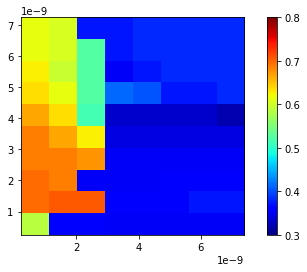

In [80]:
fig = plt.figure(figsize=(8,4))
plt.imshow(max_freqs, origin='lower', vmin=0.3, vmax=0.8, cmap='jet', extent=[g_el[0], g_el[-1], g_synA[0], g_synA[-1]])
ax = plt.gca()
plt.colorbar()
plt.show()

[0.32322579 0.3333266  0.34342741 0.35352821 0.36362902 0.37372982
 0.38383063 0.40403224 0.41413305 0.51514111 0.52524191 0.58584675
 0.59594756 0.60604836 0.61614917 0.62624997 0.63635078 0.6666532
 0.676754   0.68685481 0.69695562 0.70705642]


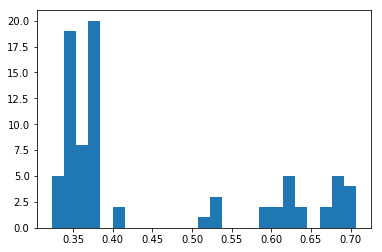

In [81]:
plt.hist(max_freqs.flatten(), 25)
print(np.unique(max_freqs.flatten()))

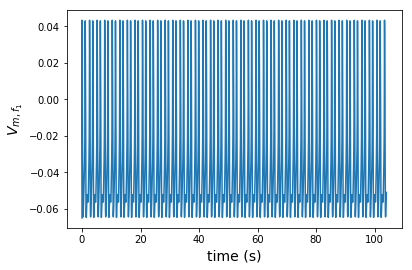

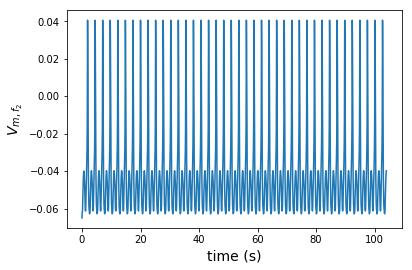

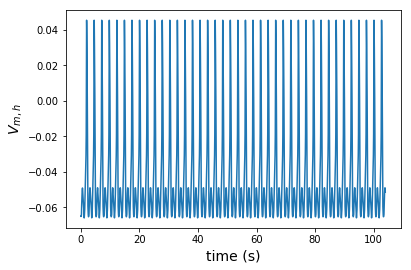

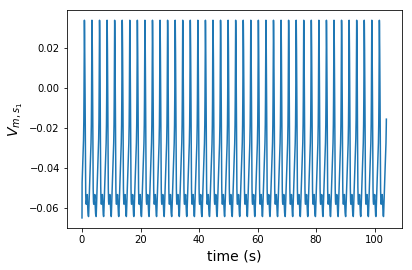

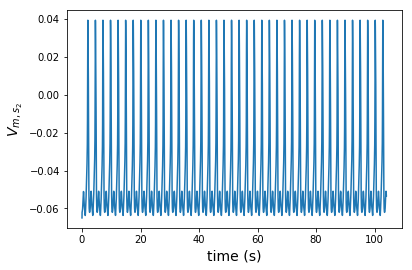

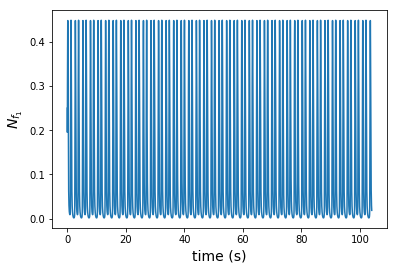

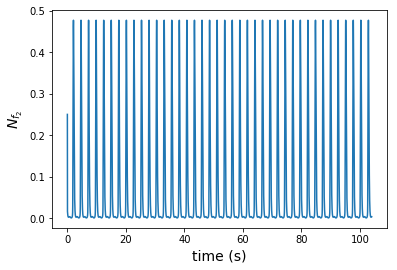

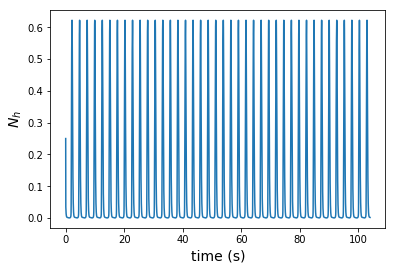

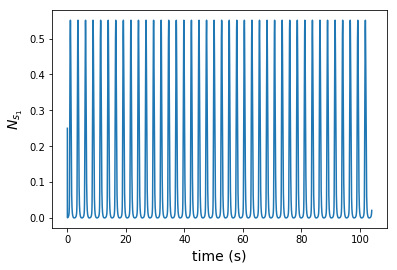

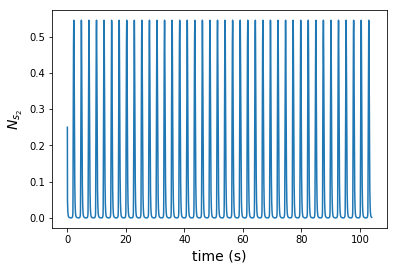

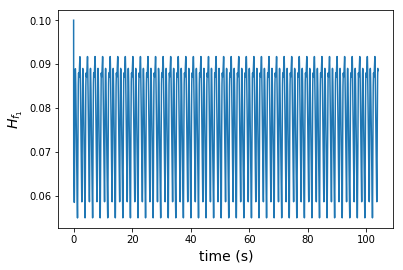

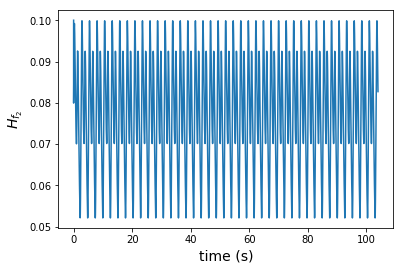

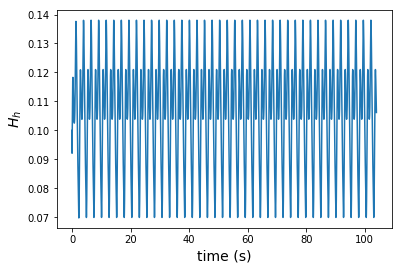

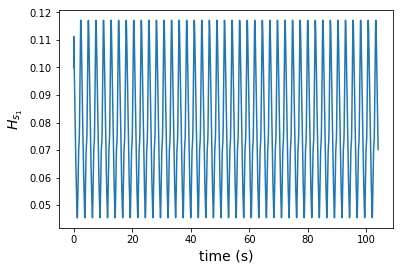

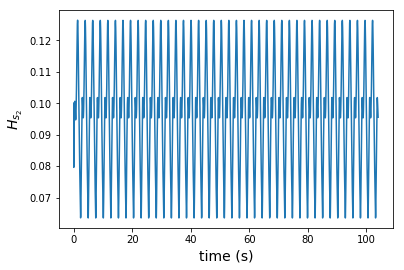

In [82]:
labels = [r'$V_{m,f_1}$', r'$V_{m,f_2}$', r'$V_{m,h}$', r'$V_{m,s_1}$', r'$V_{m,s_2}$', \
          r'$N_{f_1}$', r'$N_{f_2}$', r'$N_{h}$', r'$N_{s_1}$', r'$N_{s_2}$', \
          r'$H_{f_1}$', r'$H_{f_2}$', r'$H_{h}$', r'$H_{s_1}$', r'$H_{s_2}$']

fontsize = 14
t = np.arange(T+1) * dt
for i in range(15):
    plt.figure()
    plt.plot(t, X[:,i])
    plt.xlabel('time (s)', fontsize=fontsize)
    plt.ylabel(labels[i], fontsize=fontsize)
    plt.show()
    
x_fin = X[-1,:]